In [1]:
import cv2
import time
import math
import os
import numpy as np
import tensorflow as tf

import locality_aware_nms as nms_locality
import lanms

import model
FLAGS = tf.app.flags.FLAGS
#tf.app.flags.DEFINE_string('backbone', 'Mobilenet', 'what kind of backbone')
#tf.app.flags.DEFINE_string('dataset', 'icdar15', '')

tf.app.flags.DEFINE_string('f', '', 'kernel')
#FLAGS.backbone = 'Mobilenet' # Pvanet, Mobilenet, Resnet
#FLAGS.decoder = 'CRAFT' # original, CRAFT, Expand
#FLAGS.dataset = 'icdar2017_mlt'

from icdar import restore_rectangle
import time
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import colorsys
import random
from matplotlib import patches,  lines
%matplotlib inline

In [2]:
FLAGS.training_data_path = '/home/minjun/Jupyter/data/ocr/2013/Text_Localization/train/'
#FLAGS.training_data_path = '/home/minjun/Jupyter/data/ocr/2015/train/'
#FLAGS.dataset = 'icdar15'
FLAGS.dataset = 'icdar13'
import icdar
from eval import detect

max size :  512


In [3]:
gen = icdar.generator(vis=True,batch_size=4)

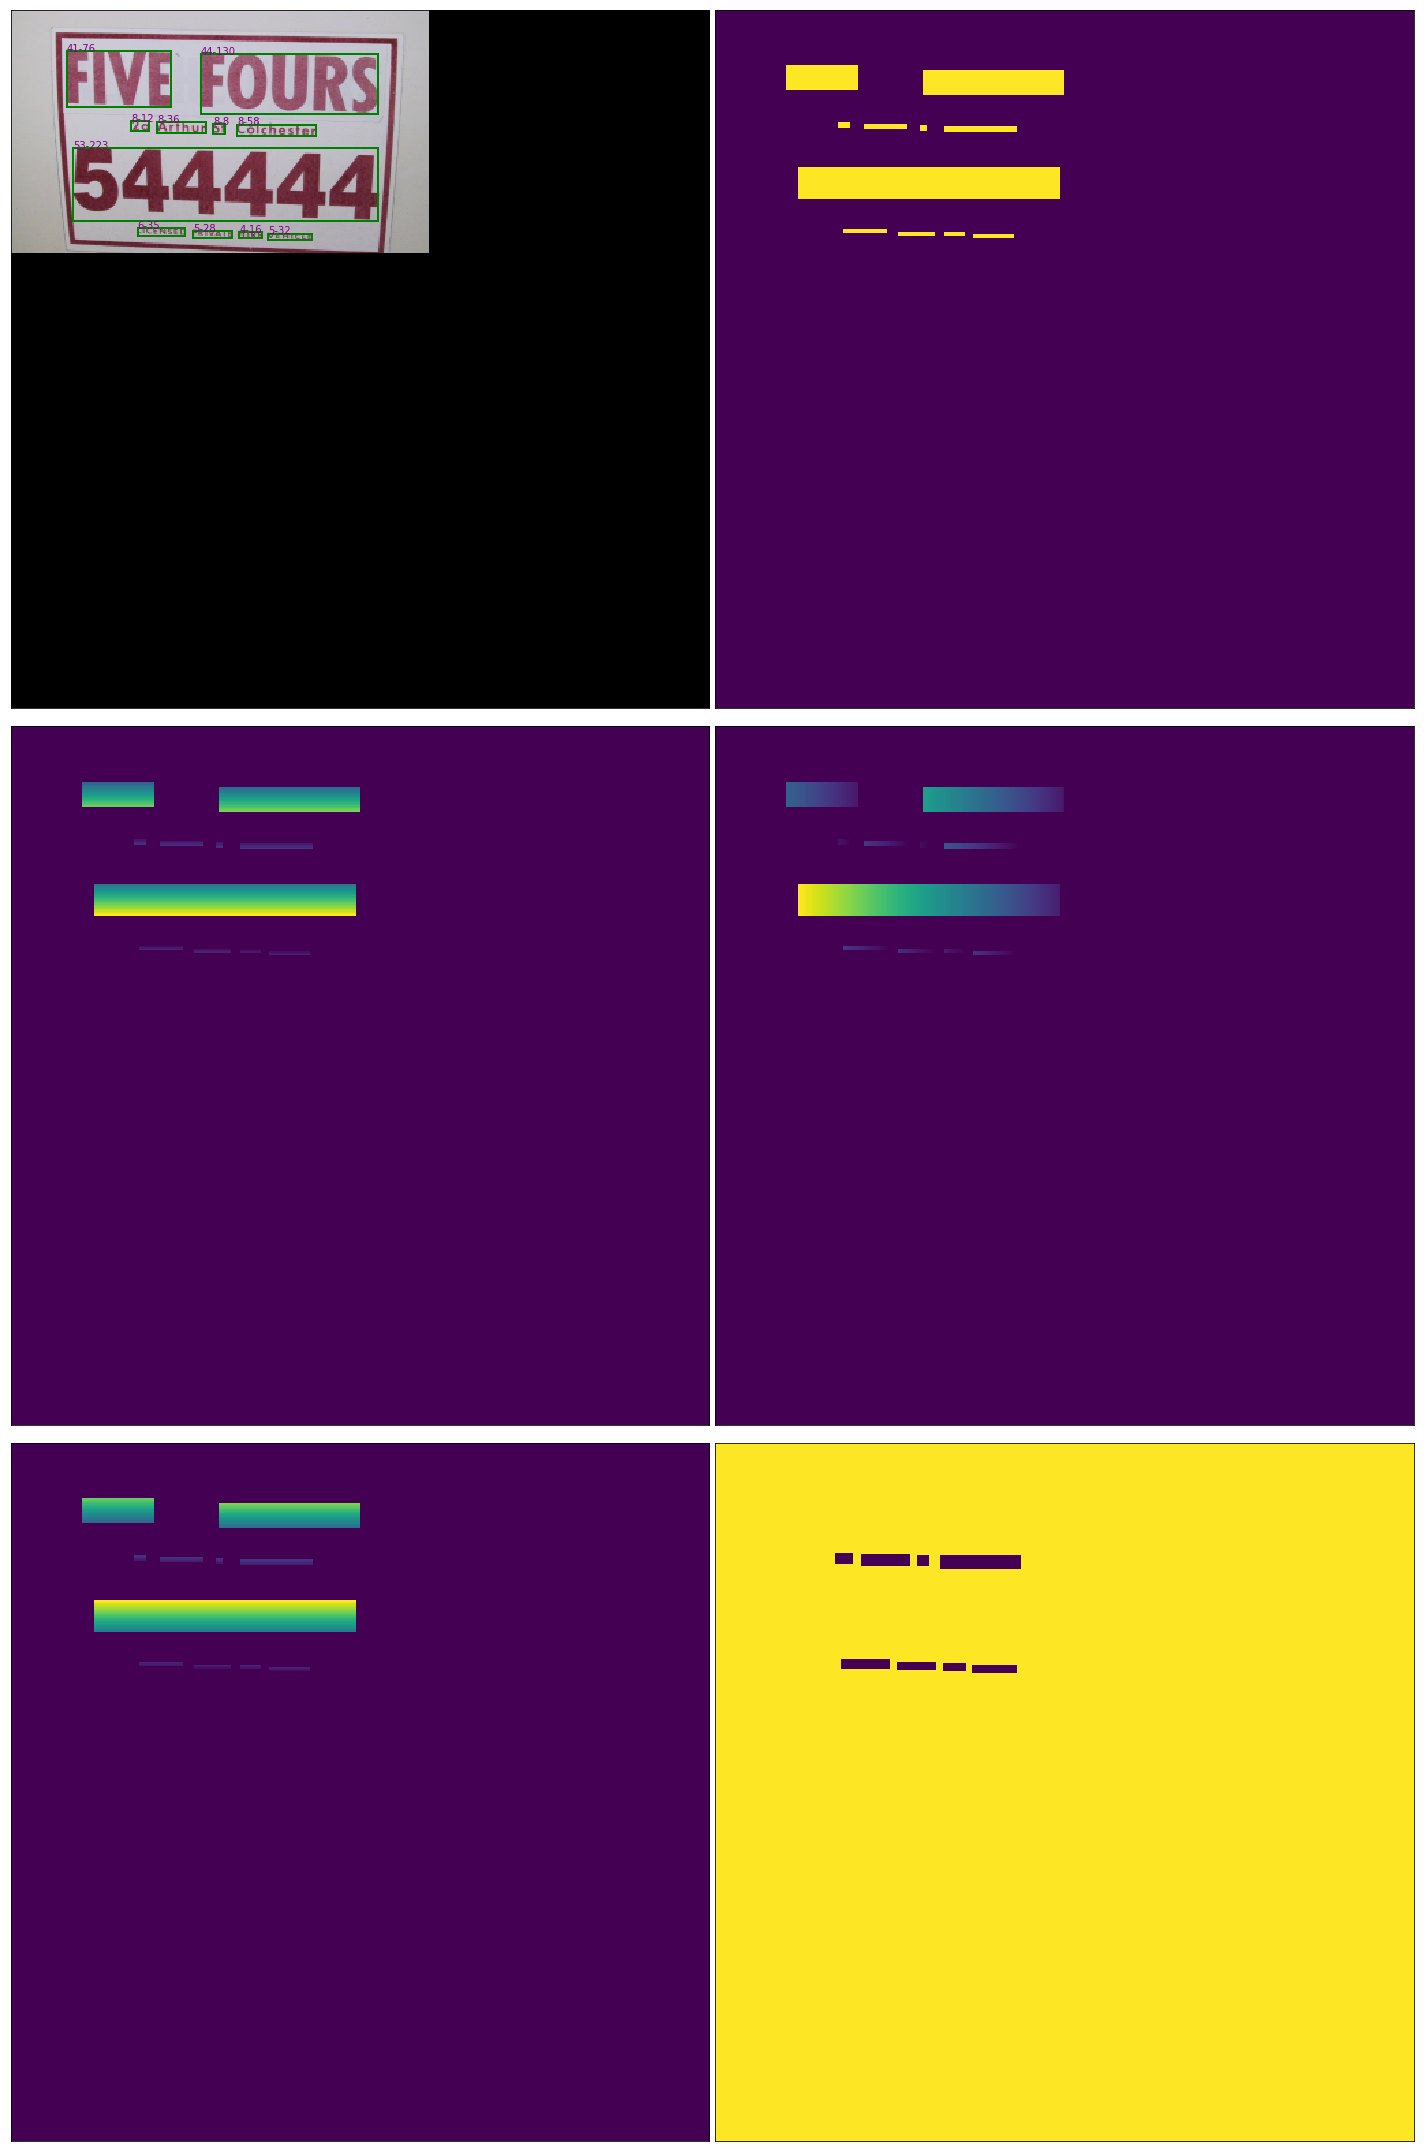

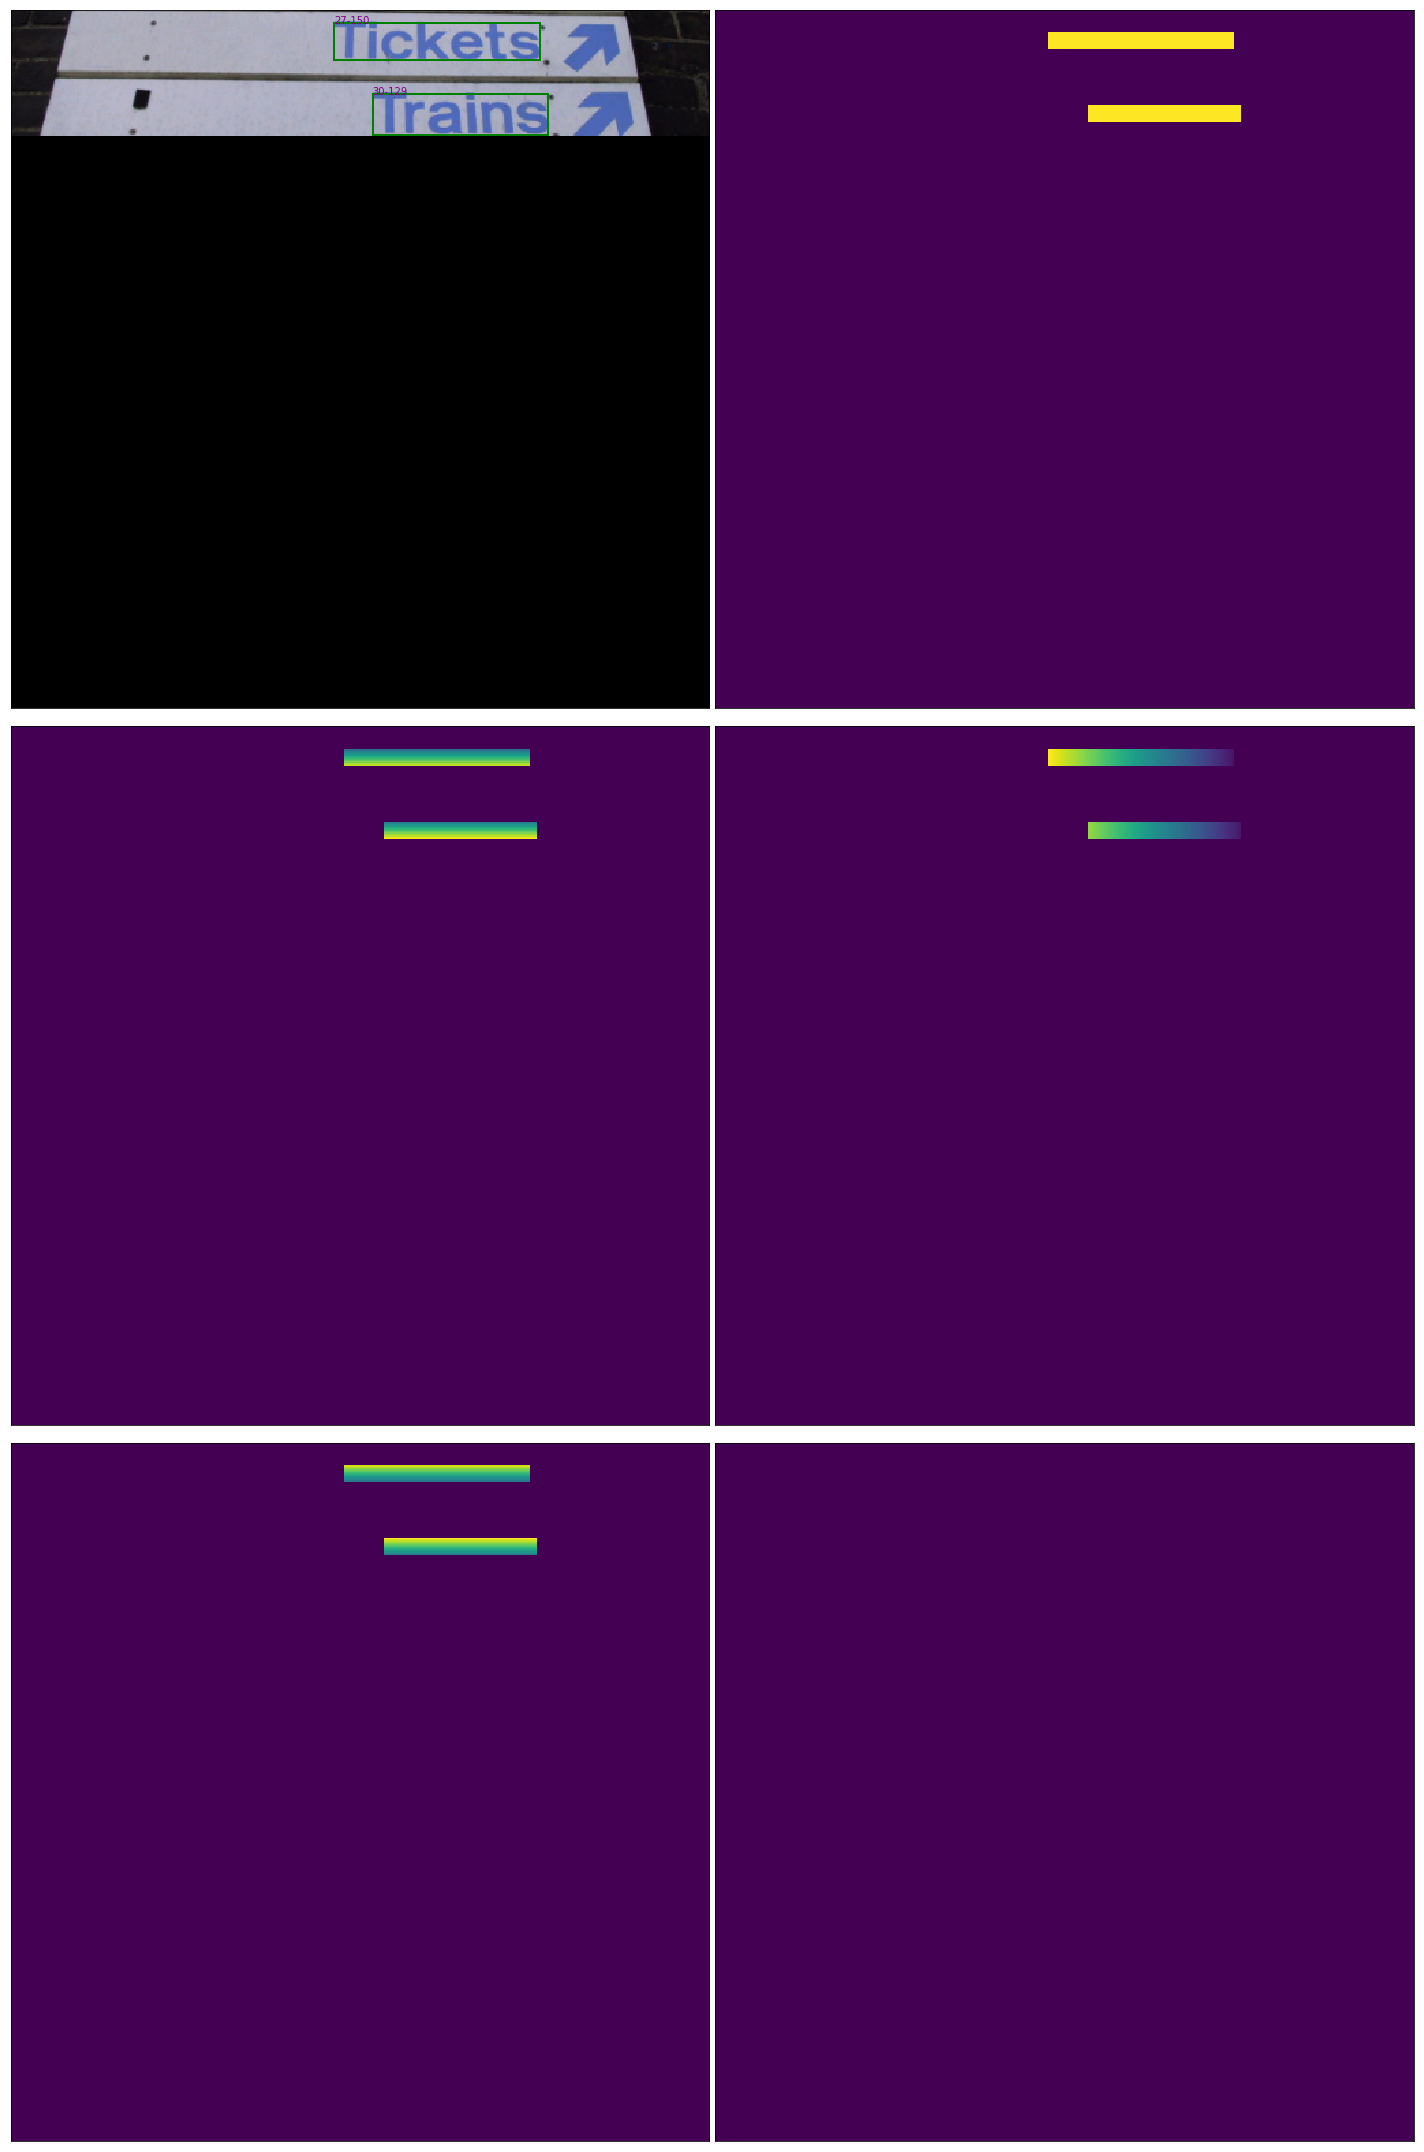

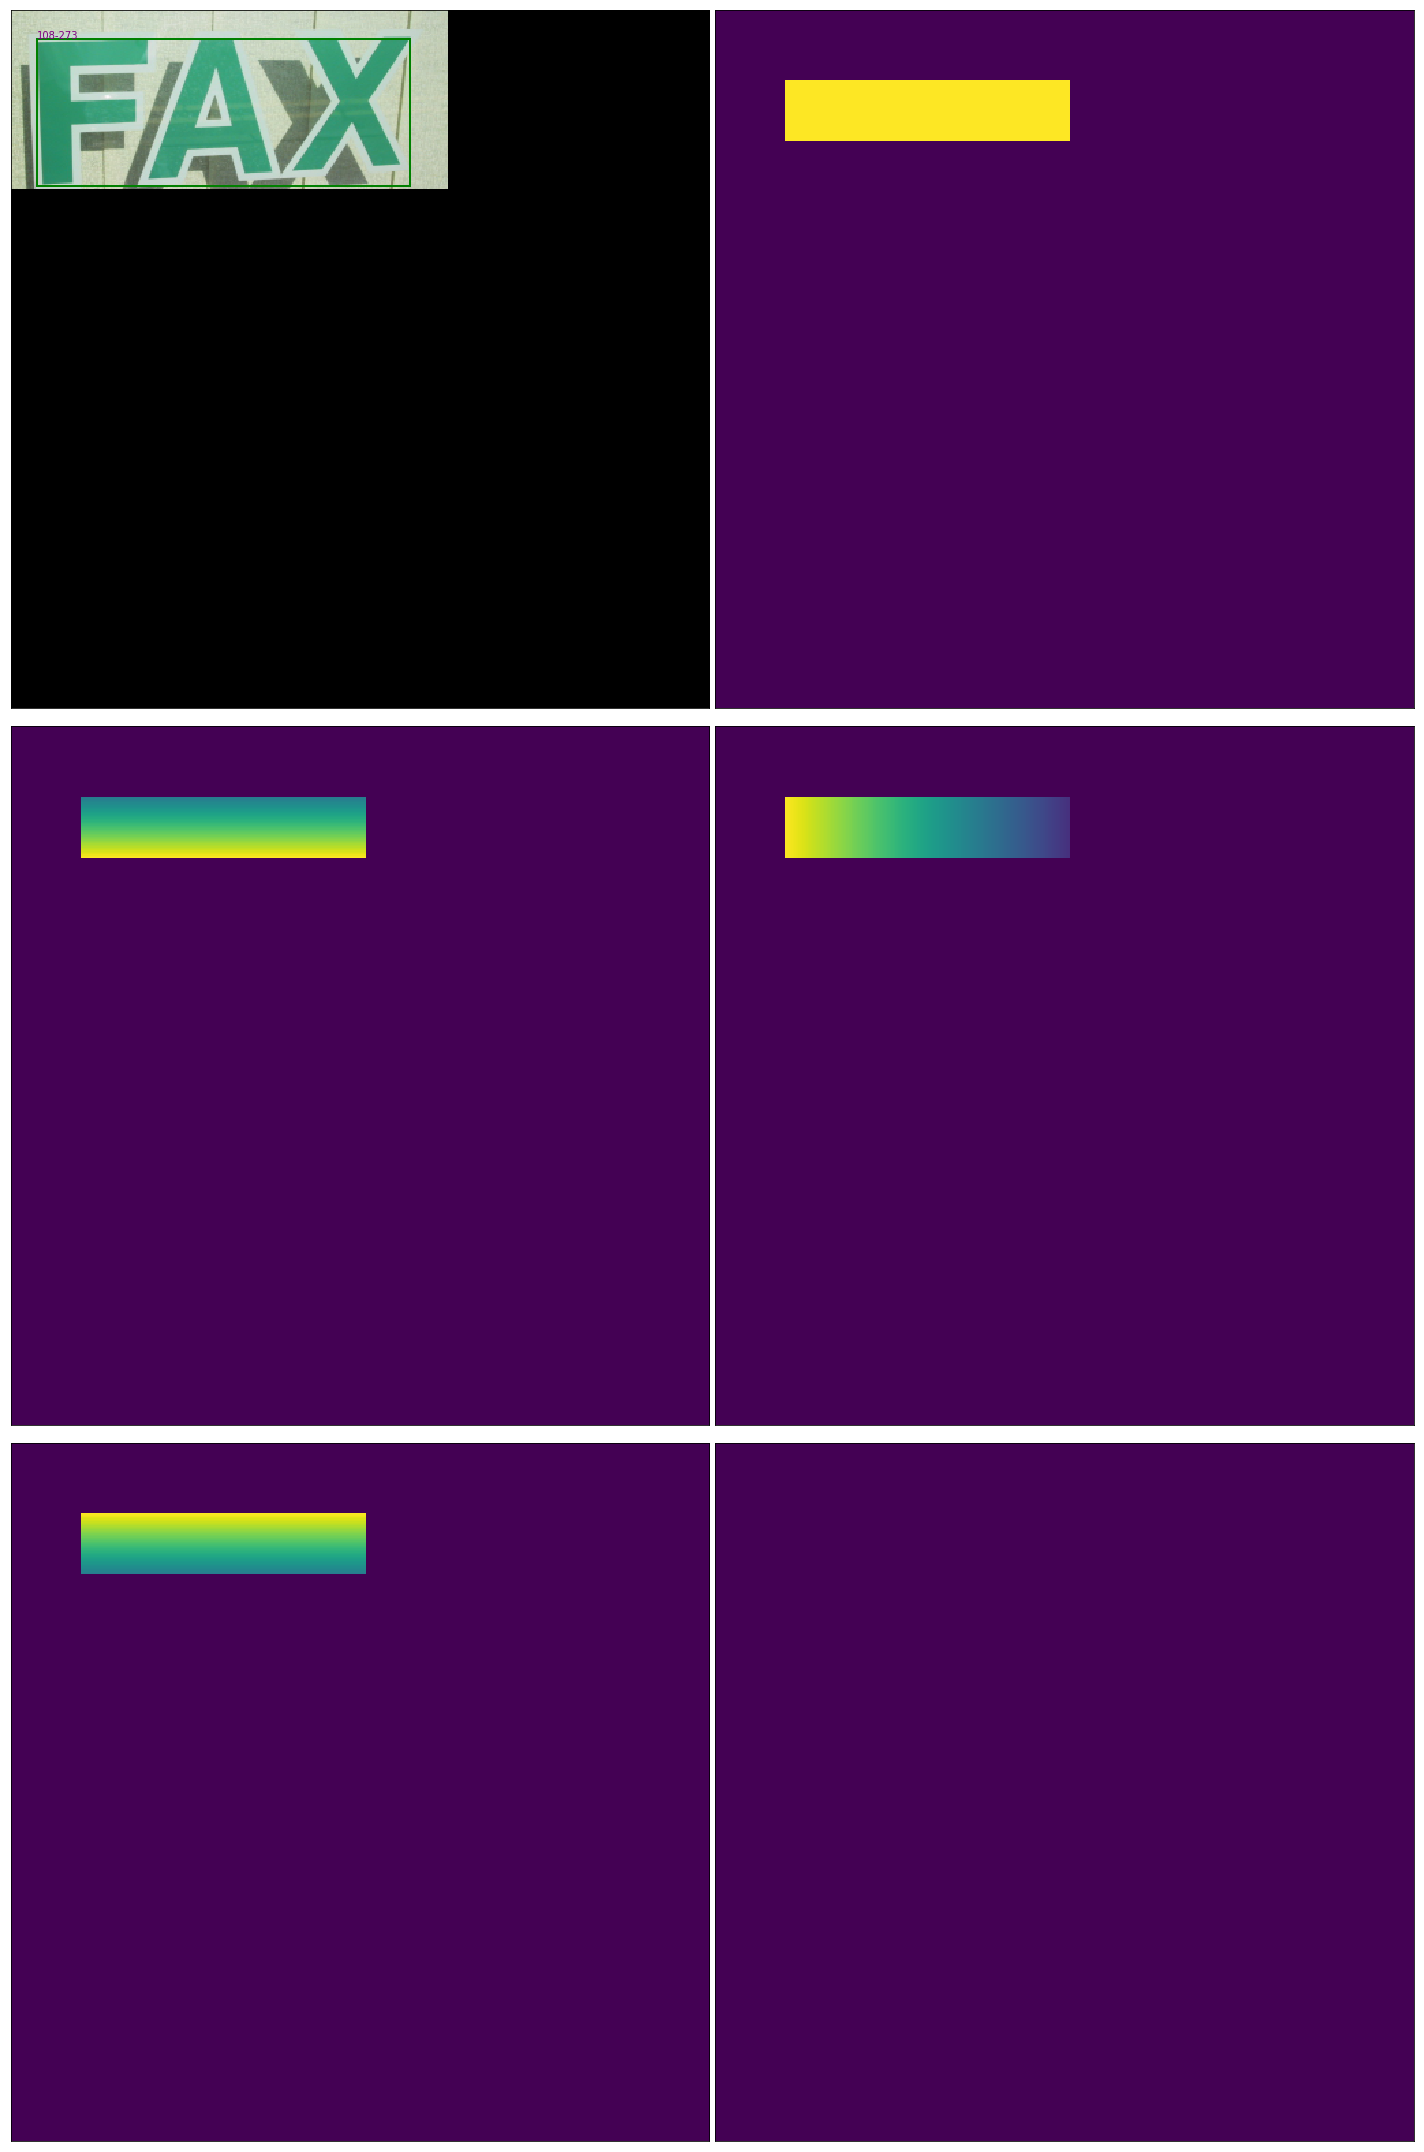

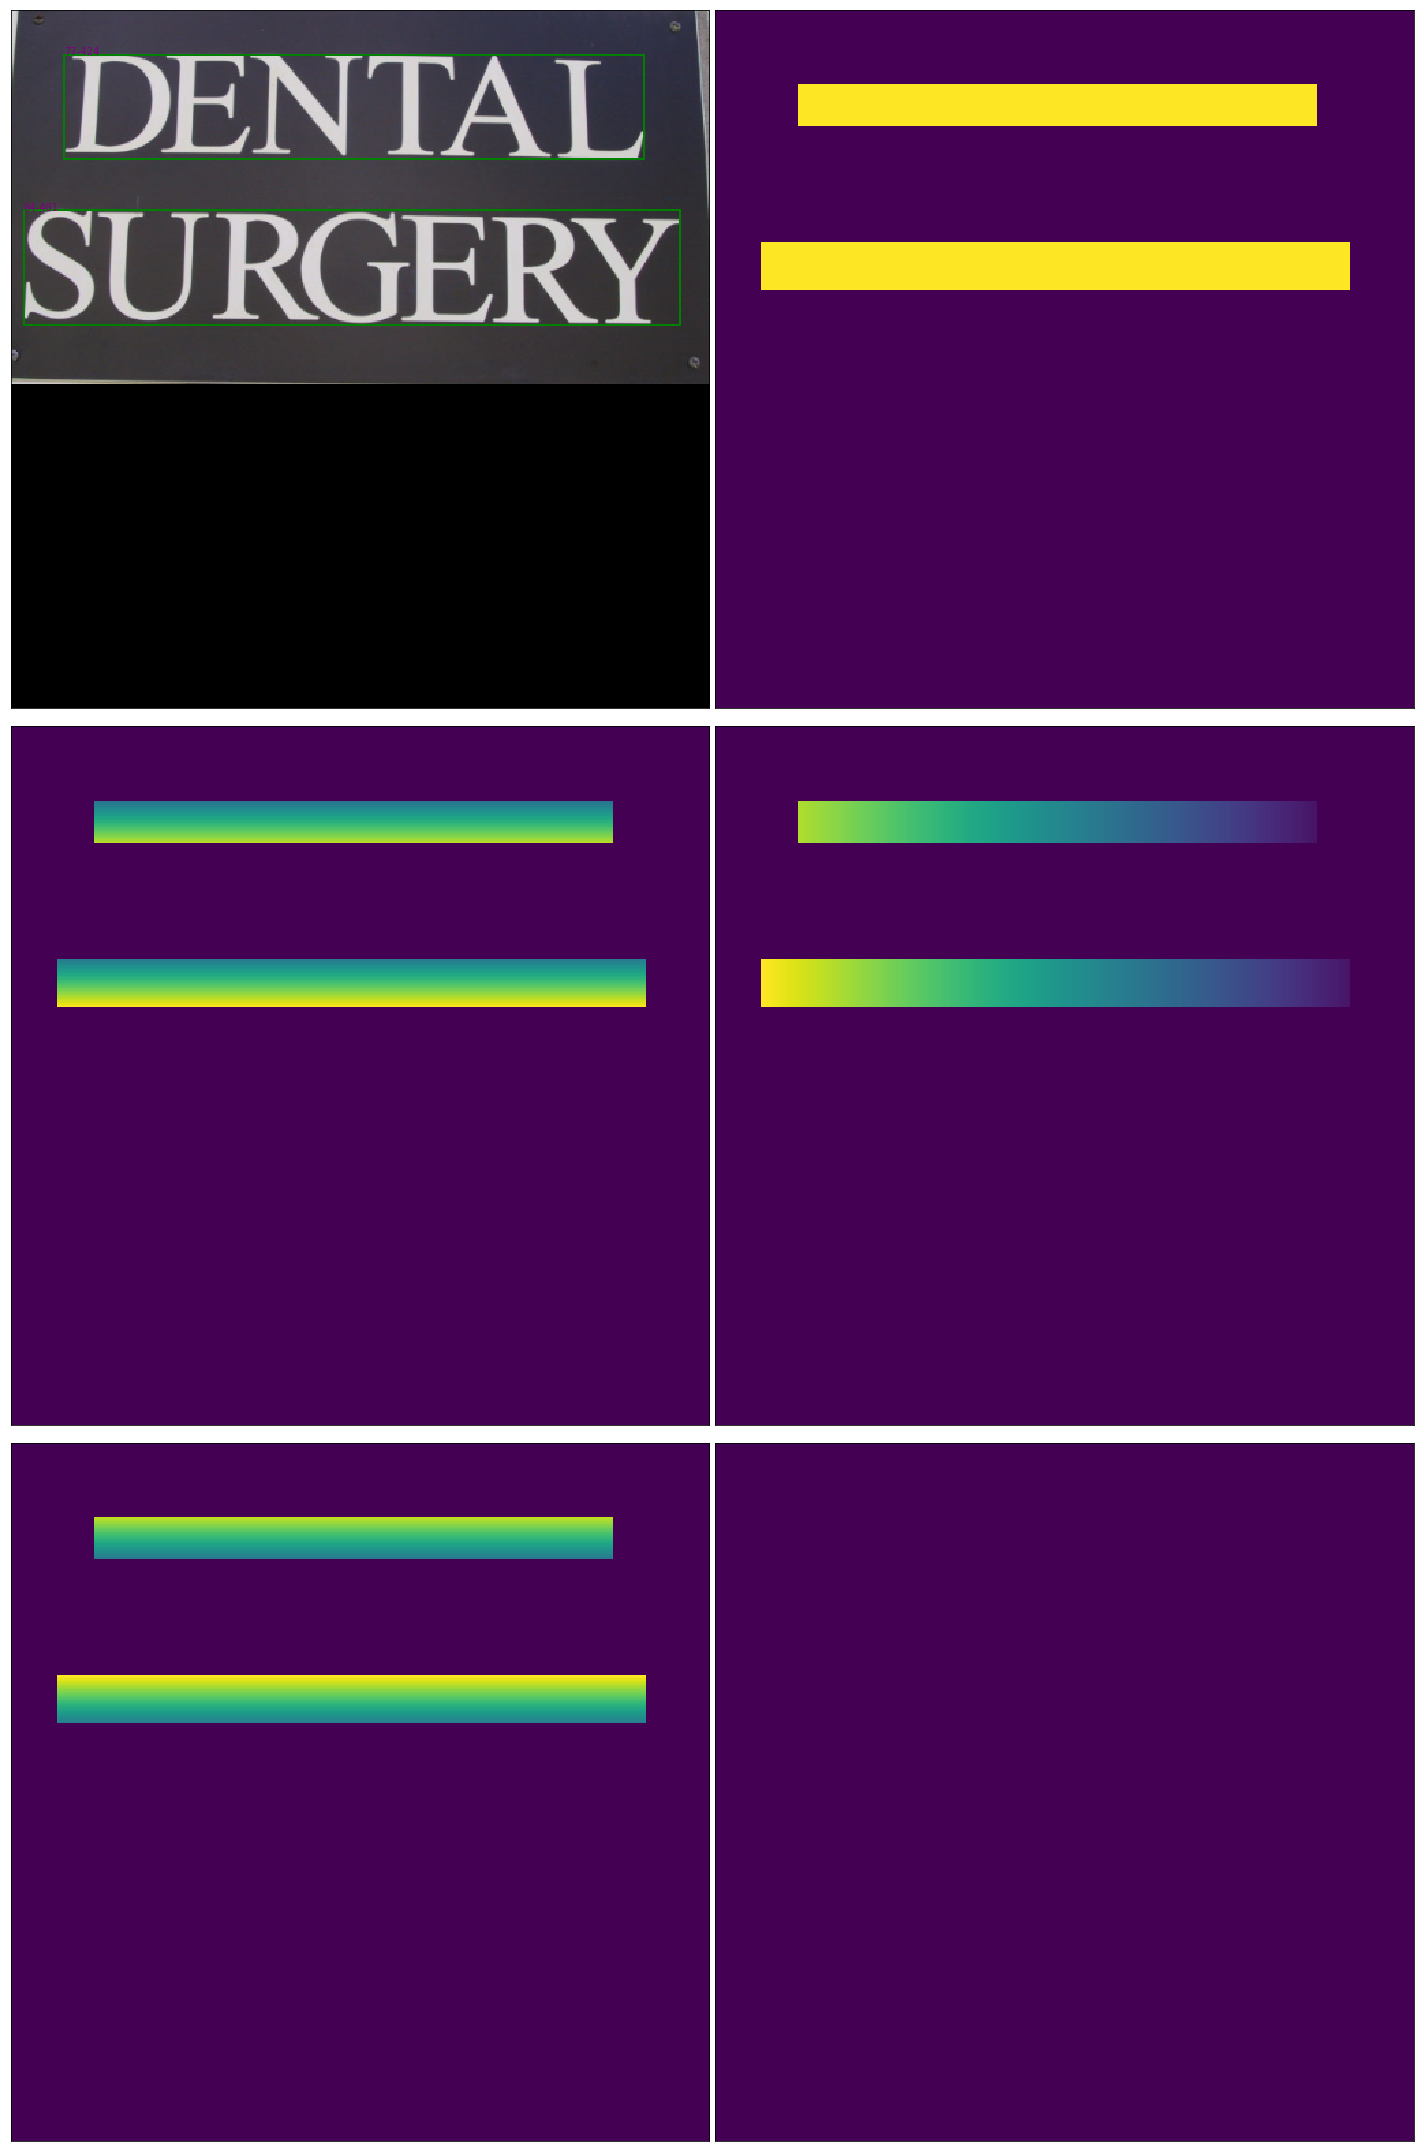

In [7]:
x = next(gen)

(5, 4)
(512, 512, 3)
(128, 128, 5)
6.796927


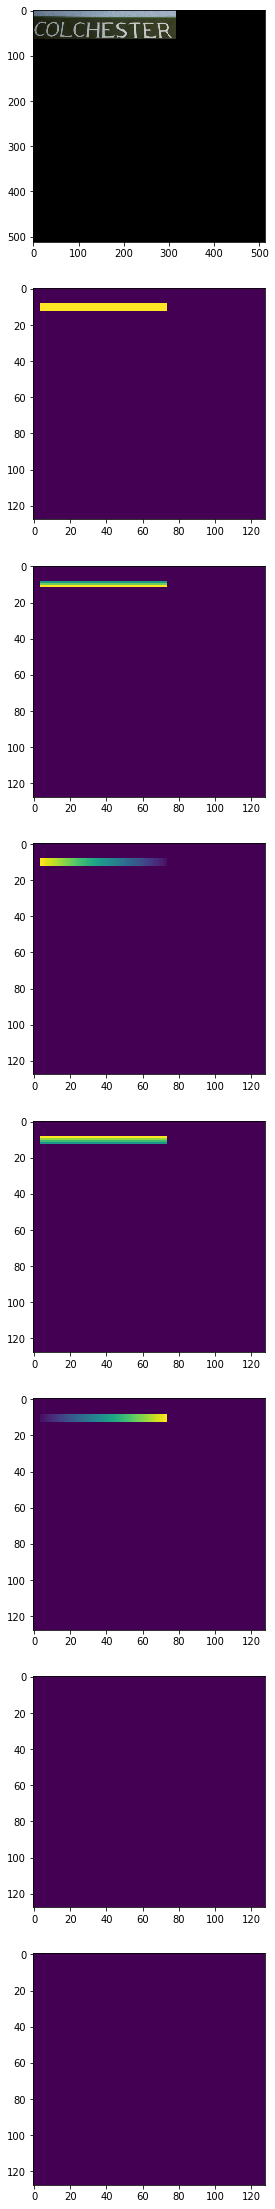

In [5]:
# generator return : images, image_fns, score_maps, geo_maps, training_masks
for i in range(1,2):
    print(np.shape(x))
    print(np.shape(x[0][i]))
    print(np.shape(x[3][i]))
    print(np.mean(x[0][i][:,:,:]))
    fig, ax = plt.subplots(8,figsize=(40,40))
    #x[3][i][:,:,1:5] = np.where(x[3][i][:,:,1:5]>20,x[3][i][:,:,1:5],0)
    
    ax[0].imshow(x[0][i][:, :, ::-1].astype(np.uint8))
    ax[1].imshow(x[2][i][:,:,0])
    ax[2].imshow(np.where(x[3][i][:,:,0]<20,x[3][i][:,:,0],0))
    ax[3].imshow(x[3][i][:,:,1])
    ax[4].imshow(x[3][i][:,:,2])
    ax[5].imshow(x[3][i][:,:,3])
    ax[6].imshow(x[3][i][:,:,4])      
    ax[7].imshow(x[4][i][:,:,0])
    

In [ ]:
len(x[3][i][:,:,4]>0)

In [ ]:
print(np.mean(x[3][i][:,:,0]))
print(np.shape(x[3][i][x[3][i][:,:,0]>5,0]))

In [ ]:
np.where(x[3][i][:,:,1:5]>10)

x[3][i][np.where(x[3][i][:,:,1:5]>10)]

In [ ]:
sess = tf.Session()
x = sess.run(tf.minimum(x[3][i][:,:,1],x[3][i][:,:,2]))

In [ ]:
score_map = np.array(x[2][3][:,:,0],np.float)
geo_map = np.array(x[3][3],np.float32)
#tmp = np.expand_dims(x[4][3][:,:,0],axis=-1)
#print(np.shape(tmp))
#geo_map = np.concatenate([gem,tmp],axis=-1)
print(np.shape(geo_map))

In [ ]:
timer = {'net': 0, 'restore': 0, 'nms': 0,'post_processing':0}
boxes, timer = detect(score,gem,timer)

In [ ]:
boxes

In [ ]:
xy_text = np.argwhere(score_map > 0.8)
# sort the text boxes via the y axis
xy_text = xy_text[np.argsort(xy_text[:, 0])]
# restore
start = time.time()
text_box_restored = restore_rectangle(xy_text[:, ::-1]*4, geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2

In [ ]:
print(np.shape(geo_map))
print(np.shape(geo_map[xy_text[:, 0], xy_text[:, 1], :]))
print(geo_map[xy_text[:, 0], xy_text[:, 1], :])

In [ ]:
origin = xy_text[:, ::-1]*4
geometry = geo_map[xy_text[:, 0], xy_text[:, 1], :]

In [ ]:
    # d1 -> top, d2->right, d3->bottom, d4->left
d = geometry[:, :4]
angle = geometry[:, 4]
# for angle > 0
origin_0 = origin[angle >= 0]
d_0 = d[angle >= 0]
angle_0 = angle[angle >= 0]
if origin_0.shape[0] > 0: # N, height1, widht1, height, widht, N , N , N ,y, x
    p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2], 
                  d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                  d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                  np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                  d_0[:, 3], -d_0[:, 2]])

    p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2
    print(p)

    rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
    rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2
    
    rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
    rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

    p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
    p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

    p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

    p3_in_origin = origin_0 - p_rotate[:, 4, :]
    new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
    new_p1 = p_rotate[:, 1, :] + p3_in_origin
    new_p2 = p_rotate[:, 2, :] + p3_in_origin
    new_p3 = p_rotate[:, 3, :] + p3_in_origin

    new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                              new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    #print(new_p_0)

In [ ]:
p_rotate[:, 3, :]

In [ ]:
p_rotate_y

In [ ]:
print(rotate_matrix_y)

In [ ]:
print(p_rotate_x)

In [ ]:
p_rotate

In [ ]:
p3_in_origin

In [ ]:
new_p_0

In [ ]:
import csv


In [ ]:
p = '/home/minjun/Jupyter/data/ocr/2013/Text_Localization/train_gt/gt_151.txt'
with open(p, 'r') as f:
    reader = csv.reader(f)
    for line in reader:
        line =list(map(float,line[0].split()[:4]))
        print(line)
